# 미니 경진대회 - 선박 도장 품질 분류

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.**

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

## Library Imports

In [1]:
# # 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
# !pip install --upgrade pip
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install opencv-python
# !sudo apt-get update
# !sudo apt-get install libgl1-mesa-glx -y
# !pip install albumentations
# !pip install timm
# !pip install transformers
# !pip install wandb
# !wandb.login(key="c7e355ee28e73332b4722183a035f1a153f7b6a7")
# !pip install nbformat

In [2]:
# --- 기본 및 데이터 처리 라이브러리 ---
import os  # 운영체제와 상호작용하기 위한 라이브러리 (파일 경로 등)
import random  # 무작위 샘플링 및 시드 고정을 위해 사용
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV, 이미지 파일을 읽고 처리하기 위한 라이브러리
import math

# --- 딥러닝(PyTorch) 관련 라이브러리 ---
import torch  # PyTorch 핵심 라이브러리
import torch.nn as nn  # 신경망 모델의 레이어나 손실 함수 등을 포함
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋과 데이터 로더를 위한 클래스


# --- PyTorch 최적화 및 스케줄러 ---
from torch.optim import AdamW  # Adam Optimizer의 개선된 버전, 딥러닝에서 널리 사용됨
from transformers import get_linear_schedule_with_warmup  # 학습률을 점진적으로 조정하는 스케줄러

# --- 이미지 증강 라이브러리 ---
import albumentations as A  # 빠르고 다양한 이미지 증강 기법을 제공하는 라이브러리
from albumentations.pytorch import ToTensorV2  # Albumentations 출력을 PyTorch 텐서로 변환

# --- 최신 이미지 모델 라이브러리 ---
import timm  # PyTorch Image Models, 거의 모든 최신 비전 모델을 쉽게 사용할 수 있게 해주는 라이브러리

# --- 진행 상황 시각화 ---
from tqdm.auto import tqdm  # for문 등 반복문의 진행 상황을 시각적으로 보여주는 라이브러리 (주피터 노트북용)

# --- 머신러닝 및 평가 라이브러리 ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# --- 실험 추적 및 로깅 ---
import wandb

# --- 시각화 및 한글 설정 ---
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
mpl.rc("font", family="NanumGothic") # Linux
# mpl.rc("font", family="AppleGothic") # Mac
# mpl.rc("font", family="Malgun Gothic") # Windows
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

In [3]:
# 모든 하이퍼파라미터와 설정을 이곳에서 관리합니다.
CFG = {
    # --- 기본 설정 ---
    "ROOT": Path("/mnt/elice/dataset/"),
    "SEED": 42,  # 재현성을 위한 랜덤 시드
    "DEVICE": torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ),  # GPU 사용 가능 여부에 따라 디바이스 설정
    # --- 모델 설정 ---
    "MODEL_NAME": "resnet34",  # timm 라이브러리에서 사용할 모델의 이름
    "NUM_CLASSES": 6,  # 분류해야 할 최종 클래스의 개수
    # --- 학습 파라미터 ---
    "IMG_SIZE": 224,  # 모델에 입력될 이미지의 크기 (가로, 세로)
    "EPOCHS": 80,  # 전체 데이터셋을 총 몇 번 학습할 것인지 (에폭)
    "LEARNING_RATE": 2e-3,  # 학습률. 모델이 얼마나 큰 폭으로 파라미터를 업데이트할지 결정
    "BATCH_SIZE": 64,  # 한 번의 반복(iteration)에서 모델에 입력할 데이터의 개수
    # --- Wandb 설정 ---
    "WANDB_DIR": None,  # wandb 실행 결과를 저장할 디렉토리 (자동 설정)
}

# Wandb 디렉토리 자동 설정
CFG["WANDB_DIR"] = "./wandb_runs" 
os.makedirs(CFG["WANDB_DIR"], exist_ok=True)
os.environ["WANDB_DIR"] = str(CFG["WANDB_DIR"])

print("✅ 환경설정 완료!")
print(f"사용할 디바이스: {CFG['DEVICE']}")
print(f"Wandb 디렉토리: {CFG['WANDB_DIR']}")

✅ 환경설정 완료!
사용할 디바이스: cuda
Wandb 디렉토리: ./wandb_runs


## Utils

In [4]:
# 랜덤 시드 고정
def set_seed(seed=42):
    random.seed(seed)  # 파이썬 표준 난수 시드
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)  # Numpy 난수 시드
    torch.manual_seed(seed)  # PyTorch CPU 연산 난수 시드
    torch.cuda.manual_seed(seed)  # CUDA 단일 GPU 난수 시드
    torch.cuda.manual_seed_all(seed)  # CUDA 다중 GPU 난수 시드
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 결정론적으로 고정
    torch.backends.cudnn.benchmark = False  # 입력 크기 탐색 비활성화


set_seed(CFG["SEED"])
print(f"✅ 시드({CFG['SEED']}) 고정 완료!")

✅ 시드(42) 고정 완료!


In [5]:
# 평가 함수
def calculate_macro_f1_for_5_classes(preds_list, labels_list):
    """6개 클래스 예측/정답을 5개 클래스 기준으로 변환하고 Macro F1 Score를 계산합니다."""
    # 리스트를 NumPy 배열로 변환
    preds_np = np.array(preds_list)
    labels_np = np.array(labels_list)

    # 핵심 로직: 클래스 인덱스가 5인 경우, 4로 변경하여 양품 클래스를 통합.
    preds_np[preds_np == 5] = 4
    labels_np[labels_np == 5] = 4

    # Macro F1 Score를 계산합니다.
    # zero_division=0 옵션은 특정 클래스 예측이 없어 F1이 0이 될 때 경고 대신 0을 반환합니다.
    macro_f1 = f1_score(labels_np, preds_np, average="macro", zero_division=0)

    return macro_f1

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

ROOT 디렉토리에는 선박 도장의 손상 정도를 파악하고 도장 품질의 검사 정확도 개선을 위한 선박 도장 상태별 이미지 데이터가 저장되어 있습니다. 데이터 이미지들은 아래와 같은 6개의 폴더에 나눠져 저장되어 있습니다.

* TS_도막 손상_도막떨어짐
* TS_도막 손상_스크래치
* TS_도장 불량_부풀음
* TS_도장 불량_이물질포함
* TS_양품_선수
* TS_양품_외판

이번 경진대회의 목표는 해당 이미지들을 활용하여 선박 도장의 손상 종류를 분류하는 것입니다. 각 폴더에 존재하는 이미지들의 라벨은 다음과 같습니다.

* TS_도막 손상_도막떨어짐 -> 도막떨어짐
* TS_도막 손상_스크래치 -> 스크래치
* TS_도장 불량_부풀음 -> 부풀음
* TS_도장 불량_이물질포함 -> 이물질포함
* TS_양품_선수 -> 양품
* TS_양품_외판 -> 양품

주의: 폴더의 경로를 찾을 수 없다는 오류 메시지가 발생하는 경우 한글 폴더 이름의 인코딩 문제일 수 있습니다. 아래 베이스라인 코드의 폴더명들을 활용하세요.

In [6]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품선",  # 양품_선수, 양품_외판 클래스 따로 분리
    "TS_양품_외판": "양품외",
}
# 모든 이미지 파일의 경로와 라벨을 저장할 리스트를 만듬.
image_data = []
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 각 폴더를 순회하며 파일 경로와 라벨을 가져옴.
for folder_name, label in folder_to_label.items():
    folder_path = CFG["ROOT"] / folder_name
    # 폴더와 하위 폴더의 모든 파일을 확인하면서 확장자를 검사.
    for image_path in folder_path.rglob("*"):
        if image_path.suffix.lower() in IMG_EXTS:  # 확장자가 IMG_EXTS에 있으면
            image_data.append({"path": str(image_path), "label": label})

# 리스트를 판다스 DataFrame으로 변환.
df = pd.DataFrame(image_data)

print(f"전체 이미지 개수: {len(df)}")
df.head()

전체 이미지 개수: 1200


path label
0  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_24f2ae...  스크래치
1  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_23b33b...  스크래치
2  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_20c5f1...  스크래치
3  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_34b46d...  스크래치
4  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_42fa37...  스크래치

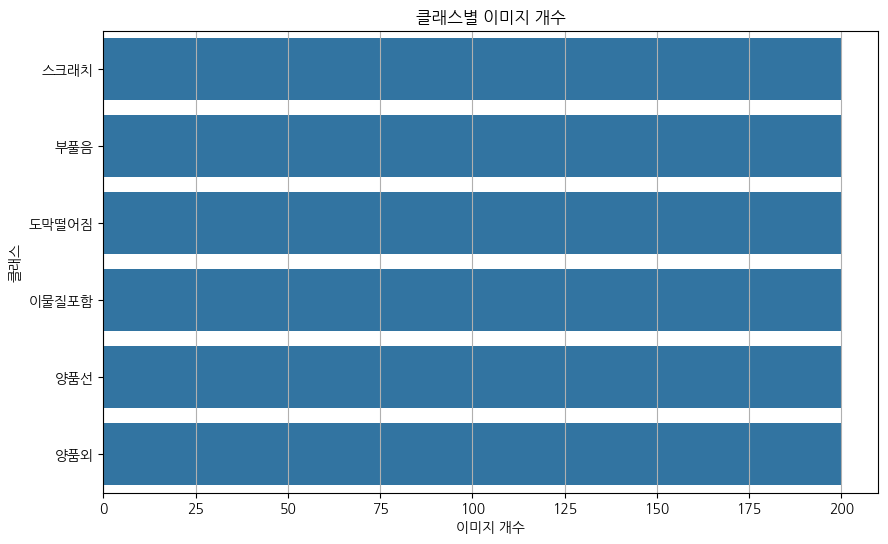

In [7]:
# 클래스별 이미지 개수 확인
plt.figure(figsize=(10, 6))
sns.countplot(y="label", data=df, order=df["label"].value_counts().index)
plt.title("클래스별 이미지 개수")
plt.xlabel("이미지 개수")
plt.ylabel("클래스")
plt.grid(axis="x")
plt.show()
# 모든 클래스 이미지 200개씩 같음

--- [ 스크래치 ] 이미지 샘플 ---


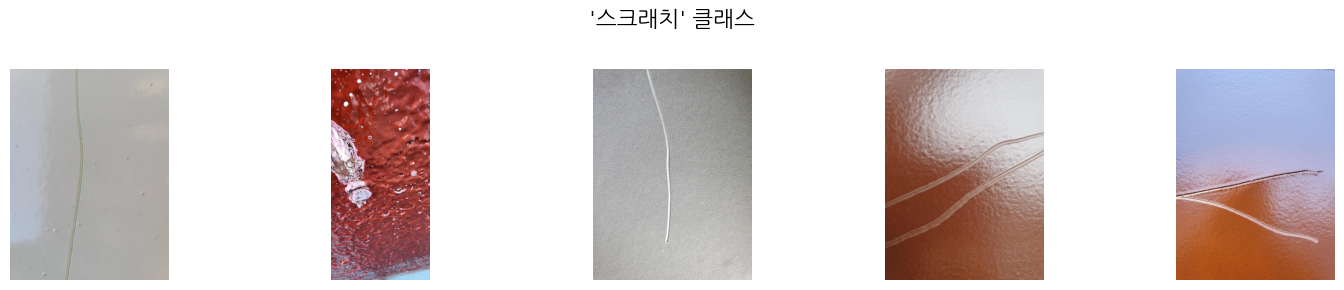



--- [ 부풀음 ] 이미지 샘플 ---


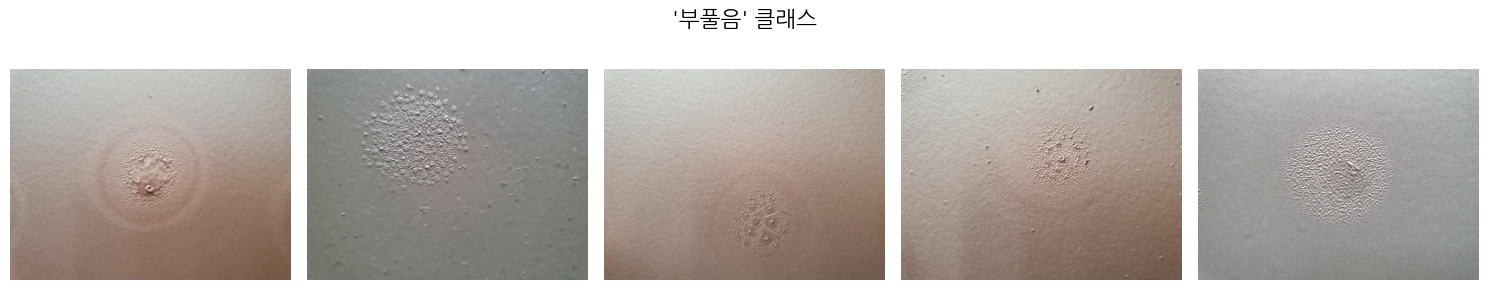



--- [ 도막떨어짐 ] 이미지 샘플 ---


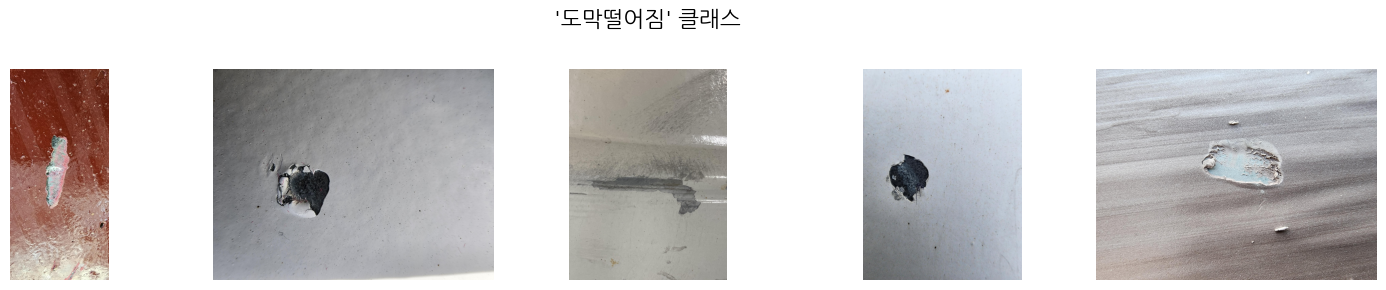



--- [ 이물질포함 ] 이미지 샘플 ---


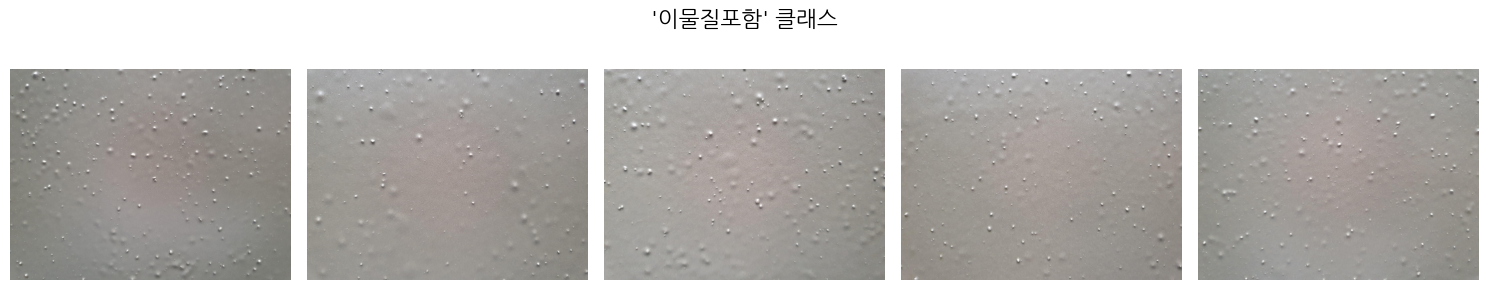



--- [ 양품선 ] 이미지 샘플 ---


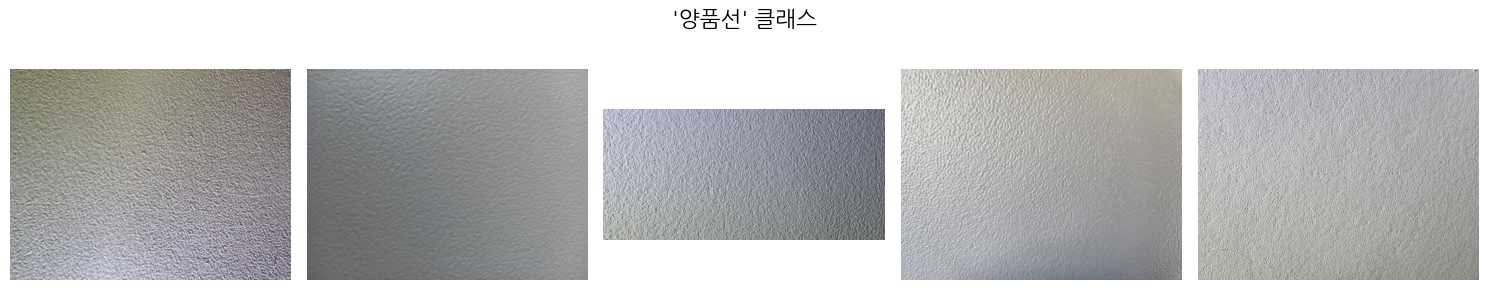



--- [ 양품외 ] 이미지 샘플 ---


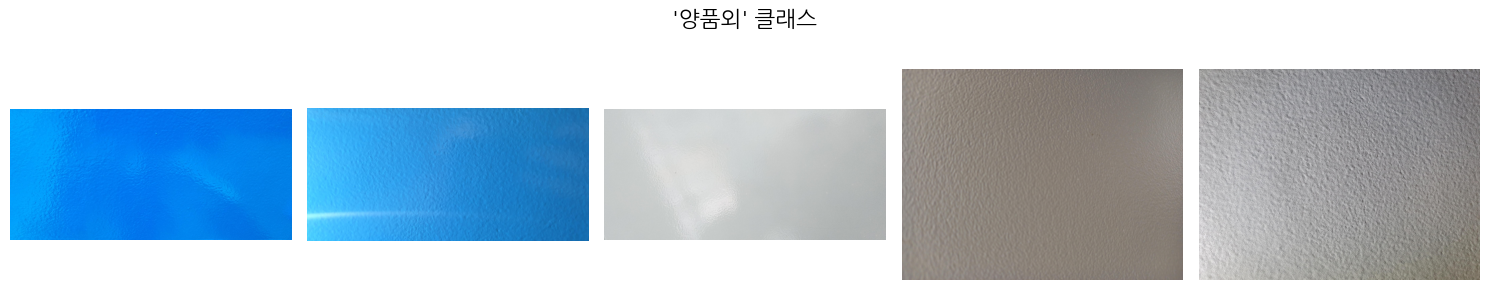

In [8]:
# 각 클래스 폴더를 돌면서 이미지 샘플을 확인.
# folder_to_label 딕셔너리의 키를 사용하여 디렉토리 경로를 구성.
for folder_name, class_name in folder_to_label.items():
    dir_path = CFG["ROOT"] / folder_name
    print(f"--- [ {class_name} ] 이미지 샘플 ---")

    # IMG_EXTS를 사용하여 모든 이미지 파일을 찾기.
    image_paths = []
    # glob으로 한 번에 여러 확장자 찾기
    for ext in IMG_EXTS:
        image_paths.extend(list(dir_path.glob(f"*{ext}")))

    # 보여줄 이미지 개수 (최대 5개)
    num_samples = min(len(image_paths), 5)

    # 이미지가 하나도 없으면 다음 폴더로
    if num_samples == 0:
        print("이미지가 없습니다.")
        continue

    # 무작위로 5개의 이미지를 선택.
    random_images = random.sample(image_paths, num_samples)

    # 1행 num_samples 열의 이미지 플롯(plot)을 생성.
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # 샘플 이미지를 하나씩 화면에 표시
    for i, img_path in enumerate(random_images):
        # 이미지 열기
        img = Image.open(img_path)

        # 해당 축(subplot)에 이미지 표시
        # 만약 axes가 단일 객체일 경우(이미지가 하나일 때)를 대비하여 조건 처리
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.axis("off")

    # 전체 플롯의 제목 설정
    fig.suptitle(f"'{class_name}' 클래스", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목과 겹치지 않도록 레이아웃 조정
    plt.show()
    print("\n")  # 클래스별 구분을 위해 줄바꿈 추가

In [9]:
def get_image_properties(path):
    """이미지 경로를 받아 너비, 높이, 모드를 반환하는 함수"""
    try:
        with Image.open(path) as img:
            return img.width, img.height, img.mode
    except Exception as e:
        print(f"오류 발생: {path}, {e}")
        return None, None, None


# progress_apply를 사용하여 각 이미지의 속성을 계산하고 새 컬럼에 저장
tqdm.pandas() # 진행 상태 확인
df[["width", "height", "mode"]] = df["path"].progress_apply(
    lambda path: pd.Series(get_image_properties(path))
)

print("\n\n--- 이미지 크기 통계 ---")
print(df[["width", "height"]].describe())

print("\n\n--- 이미지 모드(채널) 분포 ---")
print(df["mode"].value_counts())

100%|██████████| 1200/1200 [00:00<00:00, 1627.62it/s]



--- 이미지 크기 통계 ---
            width       height
count  1200.00000  1200.000000
mean   2699.88750  2212.416667
std     302.63918   372.842298
min    1272.00000  1272.000000
25%    2828.00000  2138.000000
50%    2851.00000  2138.000000
75%    2851.00000  2138.000000
max    2851.00000  2851.000000


--- 이미지 모드(채널) 분포 ---
mode
RGB    1200
Name: count, dtype: int64


1. 이미지크기가 평균 2700x2200 정도의 고해상도 이미지
2. 모두 RGB

In [10]:
# 특성(X)과 라벨(y) 정의
X = df["path"]
y = df["label"]

# 훈련 데이터와 검증 데이터로 분할 (80% 훈련, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=CFG["SEED"], stratify=y
)

print(f"훈련 데이터 샘플 수: {len(X_train)}")
print(f"검증 데이터 샘플 수: {len(X_val)}")
print("\n훈련 데이터 라벨 분포:")
print(y_train.value_counts())
print("\n검증 데이터 라벨 분포:")
print(y_val.value_counts())

훈련 데이터 샘플 수: 960
검증 데이터 샘플 수: 240

훈련 데이터 라벨 분포:
label
부풀음      160
스크래치     160
양품외      160
도막떨어짐    160
양품선      160
이물질포함    160
Name: count, dtype: int64

검증 데이터 라벨 분포:
label
도막떨어짐    40
양품외      40
이물질포함    40
스크래치     40
부풀음      40
양품선      40
Name: count, dtype: int64


## 데이터 변환(Transform)

In [11]:
# --------------------------------------------------------------------------
# 1. 모든 클래스에 적용할 통합 기본 파이프라인
# --------------------------------------------------------------------------
train_transform = A.Compose(
    [
        # 이미지 크기를 224x224로 조정
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        # 50% 확률로 좌우 반전을 적용
        A.HorizontalFlip(p=0.5),
        # 50% 확률로 상하 반전을 적용. 선박 도장 결함들은 방향에 무관
        A.VerticalFlip(p=0.5),
        # 기하학적 변형 추가
        A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.1, rotate_limit=30),
        # 밝기, 대비, 색상 변형 추가
        A.RandomBrightnessContrast(p=0.7, brightness_limit=0.2, contrast_limit=0.2),
        A.ColorJitter(p=0.5),
        # 이미지 일부를 가리는 변형 추가
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
        # ImageNet 평균/표준편차로 정규화를 수행.
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # 이미지를 PyTorch 텐서로 변환.
        ToTensorV2(),
    ]
)


# 검증(Validation) 데이터용 파이프라인은 그대로 유지.
val_transform = A.Compose(
    [
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [35]:
# --------------------------------------------------------------------------
# 2. 범용 Augmentation을 적용하는 표준 Custom Dataset
# --------------------------------------------------------------------------


class ShipDefectDataset(Dataset):

    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 이미지 경로와 라벨(클래스 이름) 가져오기
        image_path = self.image_paths[idx]
        # 라벨이 None인 경우(예: 테스트 데이터셋)를 처리
        class_name = self.labels[idx] if self.labels is not None else None

        # 이미지 불러오기 (OpenCV는 BGR 순서)
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 전달받은 transform이 있으면 적용
        if self.transform:
            augmented_image = self.transform(image=image)["image"]
        else:
            # transform이 없는 경우, 원본 이미지를 반환 (또는 기본 transform 적용)
            augmented_image = image

        # 라벨이 None이 아닐 경우에만 클래스 이름을 정수 인덱스로 변환
        # 라벨이 없는 경우를 나타내기 위해 -1을 사용
        label_idx = self.class_to_idx[class_name] if class_name is not None else -1 # Use -1 or some indicator for no label


        return augmented_image, torch.tensor(label_idx, dtype=torch.long)

In [13]:
# 라벨을 정수 인덱스로 매핑하는 딕셔너리 생성
# 고유한 라벨 목록을 얻고 이를 기반으로 인덱스를 할당
unique_labels = sorted(df["label"].unique())
class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
print(f"클래스-인덱스 매핑: {class_to_idx}")

클래스-인덱스 매핑: {'도막떨어짐': 0, '부풀음': 1, '스크래치': 2, '양품선': 3, '양품외': 4, '이물질포함': 5}


In [37]:
# 학습용 데이터셋 생성: 통합 기본 파이프라인(train_transform) 적용
train_dataset = ShipDefectDataset(
    image_paths=X_train.tolist(),
    labels=y_train.tolist(),
    class_to_idx=class_to_idx,
    transform=train_transform,
)

# 검증용 데이터셋 생성: 증강 없는 파이프라인(val_transform) 적용
val_dataset = ShipDefectDataset(
    image_paths=X_val.tolist(),
    labels=y_val.tolist(),
    class_to_idx=class_to_idx,
    transform=val_transform,
)

In [38]:
# 데이터로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=True,
    # num_workers=4, # 학습 속도 느릴때 증가 시켜보기(예: 2, 4, 8)
    # pin_memory=True,  # num_workers > 0 일 때 함께 써주기)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=False,
    # num_workers=4,
    # pin_memory=True,
)

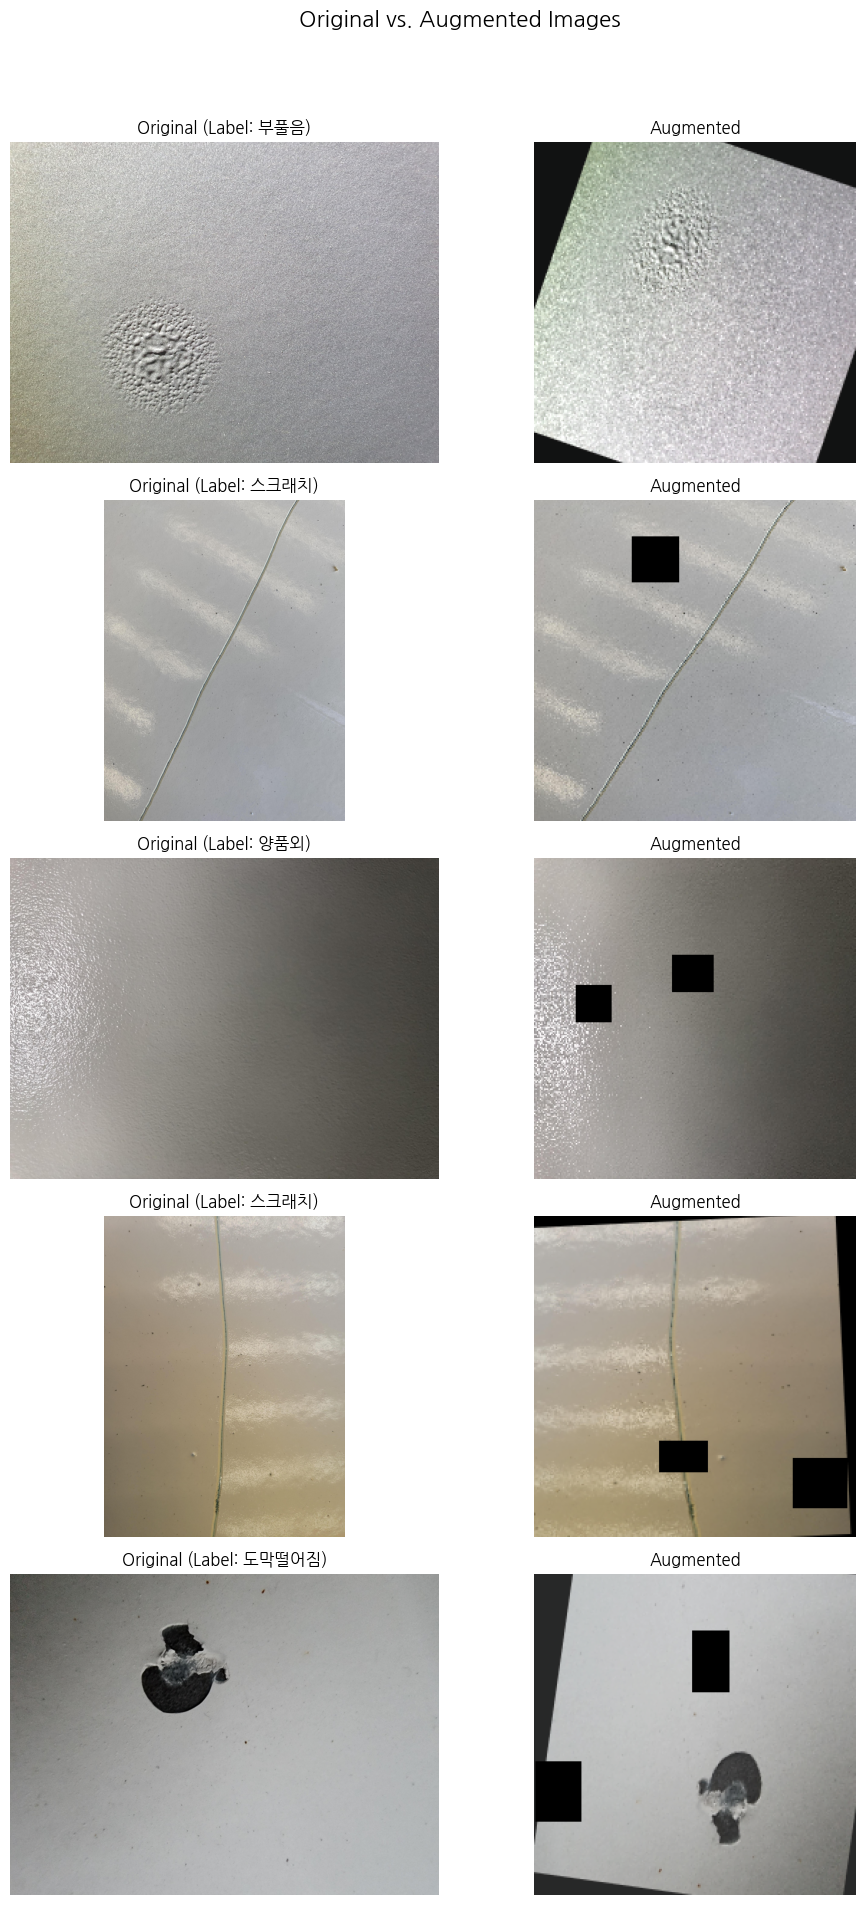

In [16]:
def visualize_augmentation(dataset, idx=0, samples=5):
    """증강 결과를 시각화하는 함수"""

    fig, axes = plt.subplots(samples, 2, figsize=(10, 4 * samples))
    fig.suptitle("Original vs. Augmented Images", fontsize=16)

    for i in range(samples):
        # 원본 이미지를 로드하기 위해 dataset.image_paths 사용
        original_img_path = dataset.image_paths[idx + i]
        original_img = cv2.imread(original_img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # 증강된 이미지와 라벨 가져오기 (Dataset의 __getitem__ 사용)
        augmented_img, label_idx = dataset[idx + i]
        label_name = list(dataset.class_to_idx.keys())[
            list(dataset.class_to_idx.values()).index(label_idx)
        ]

        # Matplotlib으로 시각화하기 위해 역정규화(denormalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # 텐서 차원 변경 (C, H, W) -> (H, W, C)
        augmented_img_np = augmented_img.permute(1, 2, 0).numpy()
        augmented_img_np = std * augmented_img_np + mean
        augmented_img_np = np.clip(
            augmented_img_np, 0, 1
        )  # 픽셀 값을 [0, 1] 범위로 클립

        # 원본 이미지 표시
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original (Label: {label_name})")
        axes[i, 0].axis("off")

        # 증강된 이미지 표시
        axes[i, 1].imshow(augmented_img_np)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 시각화 실행 ---
visualize_augmentation(train_dataset, idx=0, samples=5)

## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 로지스틱 회귀 모델을 사용합니다.

In [17]:
# =================================================================================
# 1. 학습 환경 설정
# =================================================================================
# --- 초기화 (학습 시작 전) ---
# 새로운 실험 실행을 정의합니다.

# 설정값(config) 딕셔너리 정의
config = {
    "model": CFG["MODEL_NAME"],
    "learning_rate": CFG["LEARNING_RATE"],
    "epochs": CFG["EPOCHS"],
    "batch_size": CFG["BATCH_SIZE"],
    "optimizer": "AdamW",  # 옵티마이저 직접 지정
    "weight_decay": 1e-2,  # 가중치 감쇠(Weight decay) 직접 지정
    "scheduler": "linear_schedule_with_warmup",  # 스케줄러 직접 지정
    "image_size": CFG["IMG_SIZE"],
    "augmentation": "base_transform_v2",  # 데이터 증강(Augmentation) 이름 직접 지정
}

# WandB(Weights & Biases) 실행 초기화
run = wandb.init(
    project="ship-defect-classification",  # 프로젝트 이름
    name=f"{config['model']}_{config['augmentation']}_lr_{config['learning_rate']}_{config['scheduler']}_os16",  # 실험의 고유 이름 (직접 지정)
    config=config,  # 실험에 사용된 모든 하이퍼파라미터를 기록
)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimsol1134 (kimsol1134-independent) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
# model 정의
model = timm.create_model(
    CFG["MODEL_NAME"],
    pretrained=False,
    num_classes=CFG["NUM_CLASSES"],
    output_stride=16,  # OS=16 → 224 입력이면 마지막 특징맵 14×14
)
model.to(CFG["DEVICE"])

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [19]:
# 손실 함수(loss function) 정의, 분류 문제에 주로 사용되는 CrossEntropyLoss를 사용
criterion = nn.CrossEntropyLoss()
# 최적화 도구(optimizer) 정의: AdamW 옵티마이저를 사용
optimizer = torch.optim.AdamW(
    model.parameters(), lr=CFG["LEARNING_RATE"], weight_decay=config["weight_decay"]
)

# 1. 전체 학습 스텝(iteration) 수 계산
num_training_steps = len(train_loader) * CFG["EPOCHS"]
# 2. Warm-up 스텝 수 설정 (보통 전체 스텝의 5~10%)
num_warmup_steps = int(num_training_steps * 0.05)

# Warm-up 후 선형(Linear) 형태로 감소
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

In [22]:
# =================================================================================
# 2. 훈련 및 검증 루프 시작
# =================================================================================
# 훈련 및 검증 루프 초기 설정
# 'best_val_loss'와 'best_macro_f1' 변수를 초기화합니다.
# 이 값들을 기준으로 모델 성능을 추적하고 가장 좋은 모델을 저장합니다.
best_val_loss = float("inf")
best_macro_f1 = 0.0

# 모델 체크포인트(checkpoint)를 저장할 디렉토리를 설정하고 생성합니다.

# checkpoint_dir를 문자열이 아닌 Path 객체로 정의합니다.
checkpoint_dir = Path("./checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# 모델을 주기적으로 저장할 간격을 설정합니다. 여기서는 10 에폭마다 저장합니다.
checkpoint_interval = 10


In [23]:
# 메인 훈련 루프
for epoch in range(CFG["EPOCHS"]):

    # --- 훈련(Train) 루프 ---
    model.train()  # 모델을 훈련 모드로 설정
    train_loss = 0.0

    print(f"Epoch {epoch+1}/{CFG['EPOCHS']}")
    # 훈련 데이터 로더(train_loader)를 순회하며 모델을 학습합니다.
    for images, labels in tqdm(train_loader, desc="Training"):
        # 데이터를 설정된 디바이스(CPU 또는 GPU)로 옮깁니다.
        images, labels = images.to(CFG["DEVICE"]), labels.to(CFG["DEVICE"])

        # 이전 스텝에서 계산된 기울기(gradients)를 초기화합니다.
        optimizer.zero_grad()


        # 순전파(Forward Pass): 모델에 이미지를 입력하여 출력 계산
        outputs = model(images)

        # 손실(Loss) 계산
        loss = criterion(outputs, labels)

        # 역전파(Backward Pass): 손실에 대한 기울기 계산
        loss.backward()

        # 옵티마이저로 모델의 가중치 업데이트
        optimizer.step()

        # 학습률 스케줄러를 업데이트하여 학습률을 조정합니다.
        scheduler.step()

        # 현재 스텝의 손실을 누적합니다.
        train_loss += loss.item()

    # --- 검증(Validation) 루프 ---
    model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등이 비활성화됨)
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    # 기울기 계산을 비활성화하여 메모리 사용량을 줄이고 속도를 높입니다.
    with torch.no_grad():
        # 검증 데이터 로더(val_loader)를 순회하며 모델 성능을 평가합니다.
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(CFG["DEVICE"]), labels.to(CFG["DEVICE"])
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 예측값(preds)과 실제 라벨(labels)을 리스트에 추가합니다.
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item()
            val_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 한 에폭의 평균 손실, 정확도, 매크로 F1 스코어를 계산합니다.
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_corrects.float() / len(val_loader.dataset)
    macro_f1 = calculate_macro_f1_for_5_classes(all_preds, all_labels)

    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"  Val Macro F1 Score: {macro_f1:.4f}")

    # WandB에 현재 에폭의 훈련 및 검증 지표를 기록합니다.
    wandb.log(
        {
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
            "macro_f1_score": macro_f1,
            "learning_rate": scheduler.get_last_lr()[0],
        }
    )



    # 매크로 F1 스코어가 이전 최고 기록을 경신하면 모델을 저장합니다.
    if macro_f1 > best_macro_f1:
        print(f"  >> New best F1 Score found ({macro_f1:.4f}), saving model...")
        best_macro_f1 = macro_f1
        model_save_path = checkpoint_dir / f"best_f1_model_{run.name}.pth"
        torch.save(model.state_dict(), model_save_path)

    # 주기적으로 체크포인트(checkpoint)를 저장합니다.
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pth"
        print(f"  >> Saving checkpoint at epoch {epoch+1} to {checkpoint_path}...")
        # 모델의 상태, 옵티마이저, 스케줄러 등을 딕셔너리 형태로 저장합니다.
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
                "best_val_loss": best_val_loss,
                "best_macro_f1": best_macro_f1,
                "config": config,
            },
            checkpoint_path,
        )


# 훈련이 모두 끝나면 WandB 세션을 종료합니다.
wandb.finish()
print("Training finished.")

Epoch 1/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 1.6599
  Val Loss: 1.6441, Val Accuracy: 0.2792
  Val Macro F1 Score: 0.3028
  >> New best F1 Score found (0.3028), saving model...
Epoch 2/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 1.6254
  Val Loss: 1.6071, Val Accuracy: 0.3208
  Val Macro F1 Score: 0.3531
  >> New best F1 Score found (0.3531), saving model...
Epoch 3/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 1.5501
  Val Loss: 1.7922, Val Accuracy: 0.2458
  Val Macro F1 Score: 0.2526
Epoch 4/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 1.5663
  Val Loss: 2.6809, Val Accuracy: 0.2417
  Val Macro F1 Score: 0.2412
Epoch 5/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


  Train Loss: 1.4828
  Val Loss: 2.2183, Val Accuracy: 0.3417
  Val Macro F1 Score: 0.3238
Epoch 6/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


  Train Loss: 1.3082
  Val Loss: 1.0638, Val Accuracy: 0.5875
  Val Macro F1 Score: 0.5309
  >> New best F1 Score found (0.5309), saving model...
Epoch 7/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


  Train Loss: 1.2742
  Val Loss: 1.9969, Val Accuracy: 0.4667
  Val Macro F1 Score: 0.4872
Epoch 8/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


  Train Loss: 1.1596
  Val Loss: 1.3020, Val Accuracy: 0.5667
  Val Macro F1 Score: 0.5579
  >> New best F1 Score found (0.5579), saving model...
Epoch 9/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 1.0673
  Val Loss: 0.9702, Val Accuracy: 0.5583
  Val Macro F1 Score: 0.4855
Epoch 10/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


  Train Loss: 1.0058
  Val Loss: 1.4477, Val Accuracy: 0.4958
  Val Macro F1 Score: 0.4869
  >> Saving checkpoint at epoch 10 to checkpoints/checkpoint_epoch_10.pth...
Epoch 11/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


  Train Loss: 0.9006
  Val Loss: 1.1469, Val Accuracy: 0.5917
  Val Macro F1 Score: 0.6388
  >> New best F1 Score found (0.6388), saving model...
Epoch 12/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.8120
  Val Loss: 0.8334, Val Accuracy: 0.6875
  Val Macro F1 Score: 0.6748
  >> New best F1 Score found (0.6748), saving model...
Epoch 13/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


  Train Loss: 0.7412
  Val Loss: 0.6777, Val Accuracy: 0.7542
  Val Macro F1 Score: 0.7474
  >> New best F1 Score found (0.7474), saving model...
Epoch 14/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


  Train Loss: 0.7008
  Val Loss: 0.5564, Val Accuracy: 0.7750
  Val Macro F1 Score: 0.7660
  >> New best F1 Score found (0.7660), saving model...
Epoch 15/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


  Train Loss: 0.6290
  Val Loss: 0.5264, Val Accuracy: 0.7917
  Val Macro F1 Score: 0.7753
  >> New best F1 Score found (0.7753), saving model...
Epoch 16/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


  Train Loss: 0.6006
  Val Loss: 0.5575, Val Accuracy: 0.7542
  Val Macro F1 Score: 0.7671
Epoch 17/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


  Train Loss: 0.6197
  Val Loss: 0.8788, Val Accuracy: 0.6292
  Val Macro F1 Score: 0.6185
Epoch 18/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.5737
  Val Loss: 0.6206, Val Accuracy: 0.7333
  Val Macro F1 Score: 0.7274
Epoch 19/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.5359
  Val Loss: 0.5997, Val Accuracy: 0.7500
  Val Macro F1 Score: 0.7552
Epoch 20/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.5501
  Val Loss: 0.5895, Val Accuracy: 0.7375
  Val Macro F1 Score: 0.7180
  >> Saving checkpoint at epoch 20 to checkpoints/checkpoint_epoch_20.pth...
Epoch 21/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.5183
  Val Loss: 0.4419, Val Accuracy: 0.8167
  Val Macro F1 Score: 0.8072
  >> New best F1 Score found (0.8072), saving model...
Epoch 22/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.5010
  Val Loss: 0.4984, Val Accuracy: 0.7458
  Val Macro F1 Score: 0.7020
Epoch 23/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.5839
  Val Loss: 0.5109, Val Accuracy: 0.7500
  Val Macro F1 Score: 0.7656
Epoch 24/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.4831
  Val Loss: 0.4457, Val Accuracy: 0.7958
  Val Macro F1 Score: 0.7726
Epoch 25/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.4684
  Val Loss: 0.4741, Val Accuracy: 0.7625
  Val Macro F1 Score: 0.7752
Epoch 26/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.4816
  Val Loss: 0.4167, Val Accuracy: 0.7667
  Val Macro F1 Score: 0.7269
Epoch 27/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.4271
  Val Loss: 0.3977, Val Accuracy: 0.8458
  Val Macro F1 Score: 0.8441
  >> New best F1 Score found (0.8441), saving model...
Epoch 28/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


  Train Loss: 0.4001
  Val Loss: 0.4324, Val Accuracy: 0.7917
  Val Macro F1 Score: 0.7580
Epoch 29/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


  Train Loss: 0.4240
  Val Loss: 0.3636, Val Accuracy: 0.8208
  Val Macro F1 Score: 0.8173
Epoch 30/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


  Train Loss: 0.4170
  Val Loss: 0.3733, Val Accuracy: 0.8333
  Val Macro F1 Score: 0.8330
  >> Saving checkpoint at epoch 30 to checkpoints/checkpoint_epoch_30.pth...
Epoch 31/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.3925
  Val Loss: 0.4166, Val Accuracy: 0.8208
  Val Macro F1 Score: 0.8335
Epoch 32/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.4742
  Val Loss: 0.4526, Val Accuracy: 0.7708
  Val Macro F1 Score: 0.7659
Epoch 33/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.4360
  Val Loss: 0.3540, Val Accuracy: 0.8333
  Val Macro F1 Score: 0.8365
Epoch 34/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.4214
  Val Loss: 0.3651, Val Accuracy: 0.8500
  Val Macro F1 Score: 0.8553
  >> New best F1 Score found (0.8553), saving model...
Epoch 35/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.3880
  Val Loss: 0.3766, Val Accuracy: 0.8500
  Val Macro F1 Score: 0.8568
  >> New best F1 Score found (0.8568), saving model...
Epoch 36/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3945
  Val Loss: 0.3438, Val Accuracy: 0.8583
  Val Macro F1 Score: 0.8620
  >> New best F1 Score found (0.8620), saving model...
Epoch 37/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.4010
  Val Loss: 0.3445, Val Accuracy: 0.8250
  Val Macro F1 Score: 0.8142
Epoch 38/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3992
  Val Loss: 0.4493, Val Accuracy: 0.8167
  Val Macro F1 Score: 0.8214
Epoch 39/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3783
  Val Loss: 0.5728, Val Accuracy: 0.7667
  Val Macro F1 Score: 0.7308
Epoch 40/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3838
  Val Loss: 0.3965, Val Accuracy: 0.8500
  Val Macro F1 Score: 0.8551
  >> Saving checkpoint at epoch 40 to checkpoints/checkpoint_epoch_40.pth...
Epoch 41/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3723
  Val Loss: 0.3858, Val Accuracy: 0.8417
  Val Macro F1 Score: 0.8395
Epoch 42/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


  Train Loss: 0.3808
  Val Loss: 0.4063, Val Accuracy: 0.8083
  Val Macro F1 Score: 0.7908
Epoch 43/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.3571
  Val Loss: 0.3667, Val Accuracy: 0.8417
  Val Macro F1 Score: 0.8421
Epoch 44/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3410
  Val Loss: 0.3176, Val Accuracy: 0.8583
  Val Macro F1 Score: 0.8679
  >> New best F1 Score found (0.8679), saving model...
Epoch 45/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.3312
  Val Loss: 0.3375, Val Accuracy: 0.8542
  Val Macro F1 Score: 0.8566
Epoch 46/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3144
  Val Loss: 0.3318, Val Accuracy: 0.8375
  Val Macro F1 Score: 0.8382
Epoch 47/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.3581
  Val Loss: 0.3829, Val Accuracy: 0.8458
  Val Macro F1 Score: 0.8496
Epoch 48/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3262
  Val Loss: 0.3482, Val Accuracy: 0.8375
  Val Macro F1 Score: 0.8423
Epoch 49/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.3151
  Val Loss: 0.3266, Val Accuracy: 0.8583
  Val Macro F1 Score: 0.8659
Epoch 50/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3107
  Val Loss: 0.3057, Val Accuracy: 0.8667
  Val Macro F1 Score: 0.8733
  >> New best F1 Score found (0.8733), saving model...
  >> Saving checkpoint at epoch 50 to checkpoints/checkpoint_epoch_50.pth...
Epoch 51/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.3194
  Val Loss: 0.3324, Val Accuracy: 0.8292
  Val Macro F1 Score: 0.8110
Epoch 52/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3093
  Val Loss: 0.3381, Val Accuracy: 0.8542
  Val Macro F1 Score: 0.8603
Epoch 53/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.3053
  Val Loss: 0.3305, Val Accuracy: 0.8208
  Val Macro F1 Score: 0.8042
Epoch 54/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.3061
  Val Loss: 0.3245, Val Accuracy: 0.8500
  Val Macro F1 Score: 0.8479
Epoch 55/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.2890
  Val Loss: 0.3550, Val Accuracy: 0.8625
  Val Macro F1 Score: 0.8676
Epoch 56/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.2904
  Val Loss: 0.3224, Val Accuracy: 0.8375
  Val Macro F1 Score: 0.8287
Epoch 57/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


  Train Loss: 0.3095
  Val Loss: 0.3158, Val Accuracy: 0.8708
  Val Macro F1 Score: 0.8756
  >> New best F1 Score found (0.8756), saving model...
Epoch 58/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.2850
  Val Loss: 0.3020, Val Accuracy: 0.8750
  Val Macro F1 Score: 0.8795
  >> New best F1 Score found (0.8795), saving model...
Epoch 59/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


  Train Loss: 0.2924
  Val Loss: 0.3389, Val Accuracy: 0.8792
  Val Macro F1 Score: 0.8855
  >> New best F1 Score found (0.8855), saving model...
Epoch 60/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2840
  Val Loss: 0.2788, Val Accuracy: 0.8833
  Val Macro F1 Score: 0.8913
  >> New best F1 Score found (0.8913), saving model...
  >> Saving checkpoint at epoch 60 to checkpoints/checkpoint_epoch_60.pth...
Epoch 61/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.2764
  Val Loss: 0.3019, Val Accuracy: 0.8542
  Val Macro F1 Score: 0.8555
Epoch 62/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


  Train Loss: 0.2761
  Val Loss: 0.2886, Val Accuracy: 0.8792
  Val Macro F1 Score: 0.8886
Epoch 63/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


  Train Loss: 0.2946
  Val Loss: 0.3433, Val Accuracy: 0.8417
  Val Macro F1 Score: 0.8340
Epoch 64/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.2753
  Val Loss: 0.3025, Val Accuracy: 0.8500
  Val Macro F1 Score: 0.8517
Epoch 65/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


  Train Loss: 0.2749
  Val Loss: 0.3100, Val Accuracy: 0.8667
  Val Macro F1 Score: 0.8727
Epoch 66/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


  Train Loss: 0.2678
  Val Loss: 0.3190, Val Accuracy: 0.8500
  Val Macro F1 Score: 0.8464
Epoch 67/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


  Train Loss: 0.2731
  Val Loss: 0.3230, Val Accuracy: 0.8708
  Val Macro F1 Score: 0.8772
Epoch 68/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2595
  Val Loss: 0.3039, Val Accuracy: 0.8417
  Val Macro F1 Score: 0.8461
Epoch 69/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2576
  Val Loss: 0.3005, Val Accuracy: 0.8583
  Val Macro F1 Score: 0.8552
Epoch 70/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2447
  Val Loss: 0.2899, Val Accuracy: 0.8833
  Val Macro F1 Score: 0.8900
  >> Saving checkpoint at epoch 70 to checkpoints/checkpoint_epoch_70.pth...
Epoch 71/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2591
  Val Loss: 0.3082, Val Accuracy: 0.8667
  Val Macro F1 Score: 0.8683
Epoch 72/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2433
  Val Loss: 0.3186, Val Accuracy: 0.8708
  Val Macro F1 Score: 0.8776
Epoch 73/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2446
  Val Loss: 0.3125, Val Accuracy: 0.8708
  Val Macro F1 Score: 0.8786
Epoch 74/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2515
  Val Loss: 0.3025, Val Accuracy: 0.8708
  Val Macro F1 Score: 0.8766
Epoch 75/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


  Train Loss: 0.2408
  Val Loss: 0.2976, Val Accuracy: 0.8667
  Val Macro F1 Score: 0.8723
Epoch 76/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.2404
  Val Loss: 0.2950, Val Accuracy: 0.8542
  Val Macro F1 Score: 0.8562
Epoch 77/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


  Train Loss: 0.2412
  Val Loss: 0.2946, Val Accuracy: 0.8625
  Val Macro F1 Score: 0.8650
Epoch 78/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


  Train Loss: 0.2465
  Val Loss: 0.2920, Val Accuracy: 0.8667
  Val Macro F1 Score: 0.8703
Epoch 79/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


  Train Loss: 0.2302
  Val Loss: 0.2950, Val Accuracy: 0.8708
  Val Macro F1 Score: 0.8745
Epoch 80/80


Validation: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


  Train Loss: 0.2304
  Val Loss: 0.2956, Val Accuracy: 0.8625
  Val Macro F1 Score: 0.8655
  >> Saving checkpoint at epoch 80 to checkpoints/checkpoint_epoch_80.pth...


Training finished.


========== 최종 성능 요약 ==========
📊 Macro F1 Score: 0.8655
Average Train Loss: 0.2304
Average Val Loss: 0.2956

========== 상세 분류 리포트 ==========
              precision    recall  f1-score   support

       도막떨어짐       0.92      0.90      0.91        40
         부풀음       0.95      0.97      0.96        40
        스크래치       0.88      0.90      0.89        40
         양품선       0.71      0.72      0.72        40
         양품외       0.71      0.68      0.69        40
       이물질포함       1.00      1.00      1.00        40

    accuracy                           0.86       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.86      0.86       240


========== 혼동 행렬 시각화 ==========


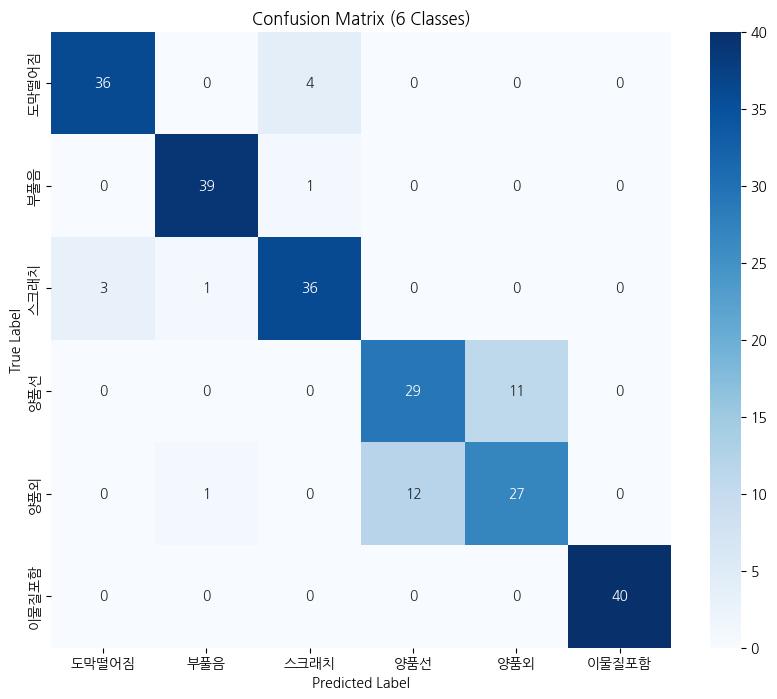

In [24]:
# 학습 루프 종료 후, 최종 성능 요약 출력
print(f"========== 최종 성능 요약 ==========")
print(f"📊 Macro F1 Score: {macro_f1:.4f}")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Val Loss: {avg_val_loss:.4f}")
print("===================================\n")

# 2. 클래스별 상세 리포트 출력
print("========== 상세 분류 리포트 ==========")
report = classification_report(
    all_labels, all_preds, target_names=list(class_to_idx.keys())
)
print(report)
print("===================================\n")

# 3. 혼동 행렬(Confusion Matrix) 시각화
print("========== 혼동 행렬 시각화 ==========")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(class_to_idx.keys()),
    yticklabels=list(class_to_idx.keys()),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (6 Classes)")
plt.show()

In [25]:
# 클래스 인덱스 정의 (class_to_idx 딕셔너리에 맞게)
# 예시: '도막떨어짐' -> 0, '부풀음' -> 2

# 혼동 행렬을 보고 가장 많이 오분류된 클래스 쌍의 인덱스를 확인합니다.
# 예를 들어, 혼동 행렬에서 True='도막떨어짐' 행, Pred='부풀음' 열의 값이 높다면
# 다음과 같이 인덱스를 설정합니다.
TRUE_CLASS_IDX = 0 # 예를 들어 '도막떨어짐'의 인덱스
PRED_CLASS_IDX = 2 # 예를 들어 '부풀음'의 인덱스

In [46]:
def find_error_indices(true_class_idx, pred_class_idx, labels, preds):
    """
    특정 오분류 케이스의 인덱스를 찾는 함수
    
    Args:
        true_class_idx (int): 실제 클래스 인덱스
        pred_class_idx (int): 예측 클래스 인덱스
        labels (np.array): 실제 라벨 배열
        preds (np.array): 예측 결과 배열
    
    Returns:
        list: 오분류된 이미지들의 인덱스 리스트
    """
    # 실제로는 true_class_idx인데 pred_class_idx로 예측된 케이스 찾기
    misclassified_mask = (labels == true_class_idx) & (preds == pred_class_idx)
    misclassified_indices = np.where(misclassified_mask)[0].tolist()
    
    return misclassified_indices

def plot_error_images(indices, dataset, class_names, num_cols=5):
    """
    오분류된 이미지들을 시각화하는 함수
    
    Args:
        indices (list): 시각화할 이미지들의 인덱스
        dataset: 데이터셋 객체
        class_names (list): 클래스 이름 리스트
        num_cols (int): 한 행에 표시할 이미지 개수
    """
    if not indices:
        print("시각화할 오분류 이미지가 없습니다.")
        return
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    num_images = len(indices)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
    
    # 단일 행인 경우 axes를 2D 배열로 변환
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        
        try:
            image, label = dataset[idx]
            
            # PyTorch 텐서를 NumPy 배열로 변환
            image_np = image.cpu().numpy()
            
            # (C, H, W) -> (H, W, C) 차원 변경
            if len(image_np.shape) == 3 and image_np.shape[0] in [1, 3]:
                image_np = np.transpose(image_np, (1, 2, 0))
            
            # --- 역정규화 로직 수정 ---
            image_np = std * image_np + mean
            
            # 값 범위를 [0, 1]로 안전하게 클리핑
            image_np = np.clip(image_np, 0, 1)
            # --------------------------
            
            ax.imshow(image_np)
            
            true_class = class_names[label]
            title = f"Idx: {idx}\nTrue: {true_class}"
            ax.set_title(title, fontsize=10)
            ax.axis('off')
            
        except Exception as e:
            print(f"인덱스 {idx}의 이미지를 로드하는 중 오류 발생: {e}")
            ax.text(0.5, 0.5, f'Error\nIdx: {idx}', ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            
    
    # 빈 서브플롯 숨기기
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

--- 분석: True='도막떨어짐', Pred='스크래치' ---
총 4개의 이미지를 잘못 분류했습니다.



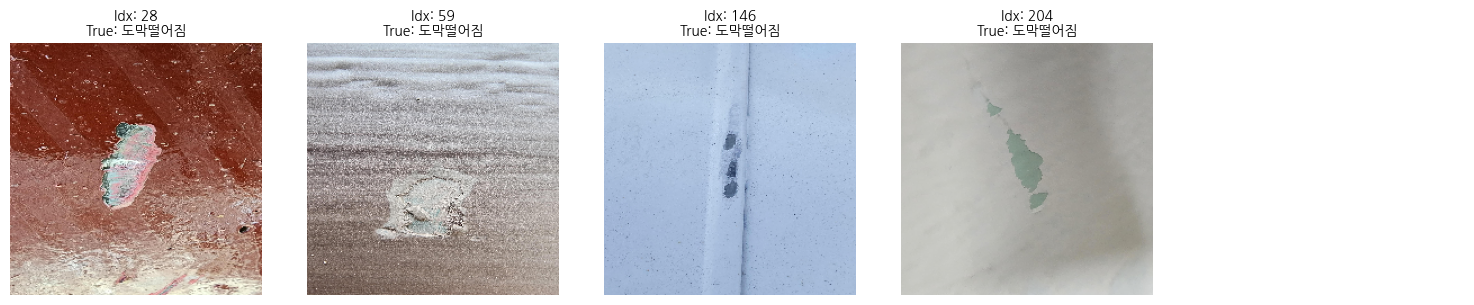

In [47]:

# 특정 오분류 케이스의 인덱스를 찾기
misclassified_indices = find_error_indices(
    true_class_idx=TRUE_CLASS_IDX,
    pred_class_idx=PRED_CLASS_IDX,
    labels=np.array(all_labels),
    preds=np.array(all_preds),
)

print(f"--- 분석: True='{list(class_to_idx.keys())[TRUE_CLASS_IDX]}', Pred='{list(class_to_idx.keys())[PRED_CLASS_IDX]}' ---")
print(f"총 {len(misclassified_indices)}개의 이미지를 잘못 분류했습니다.\n")

# 해당 이미지들 시각화
# 시각화할 이미지 개수 제한 (너무 많으면 노트북 성능 저하 및 출력 과다)
num_images_to_plot = min(len(misclassified_indices), 20) # 최대 20개 시각화
plot_error_images(misclassified_indices[:num_images_to_plot], val_dataset, list(class_to_idx.keys()))

# 다른 오분류 케이스를 분석하고 싶다면 TRUE_CLASS_IDX와 PRED_CLASS_IDX를 변경하여 이 셀을 다시 실행하세요.

## 모델 평가 및 결과 저장

분류 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **F1 Score**를 사용합니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에서 명시한 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

`submission.csv` 파일은 채점을 위한 코드입니다. index로는 테스트 데이터의 파일 이름들을, "label"열에는 해당 이미지 파일의 손상 종류를 저장해야 합니다. 아래와 같은 형태의 데이터프레임을 만든 뒤 `submission.csv` 파일로 저장해야 합니다.
* 아래 데이터프레임은 예시입니다.
   
|      | label |
| --------- | ----- |
| 00001.jpg | 양품    |
| 00002.jpg | 스크래치    |
| 00003.jpg | 양품    |
| 00004.jpg | 도막떨어짐    |
| 00005.jpg | 양품    |

In [39]:
# 1. best model 로드
# Define the path to the best model checkpoint
best_model_path = checkpoint_dir / f"best_f1_model_{run.name}.pth"

# Load the model state dictionary
model.load_state_dict(torch.load(best_model_path))
model.to(CFG["DEVICE"]) 
print(f"✅ Best model loaded from {best_model_path}")

✅ Best model loaded from checkpoints/best_f1_model_resnet34_base_transform_v2_lr_0.002_linear_schedule_with_warmup_os16.pth


In [40]:
# 2. 테스트 데이터셋 준비
TEST_ROOT = CFG["ROOT"] / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 테스트 이미지 경로 수집
test_image_paths = []
for p in TEST_ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        test_image_paths.append(str(p))

#  파일명을 기준으로 경로를 정렬하여 일관된 순서 유지
test_image_paths = sorted(test_image_paths, key=lambda x: Path(x).name)

# 테스트 데이터셋을 위한 임시 라벨 리스트 생성 (추론 시에는 실제 라벨이 없음)
# 추론에는 이미지 경로만 필요함
test_labels_dummy = [None] * len(test_image_paths)

# 검증용 transform을 사용하여 테스트 데이터셋 생성
test_dataset = ShipDefectDataset(
    image_paths=test_image_paths,
    labels=test_labels_dummy, # Dummy labels
    class_to_idx=class_to_idx, # Use the same class_to_idx mapping
    transform=val_transform, # Use validation transform (no augmentation)
)

# 테스트 데이터로더 생성
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=False, # No need to shuffle test data
    # num_workers=4,
    # pin_memory=True,
)

print(f"✅ {len(test_image_paths)}개의 이미지로 테스트 데이터셋 준비 완료.")

✅ Test dataset prepared with 1000 images.


In [41]:
# 3. 추론 수행
model.eval()  # 모델을 평가 모드로 설정
test_preds = []
test_filenames = []

with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Predicting on test set"):
        images = images.to(CFG["DEVICE"]) # 이미지를 지정된 장치(GPU 등)로 이동
        outputs = model(images) # 모델에 이미지를 입력하여 결과(logits) 출력
        _, preds = torch.max(outputs, 1) # 가장 높은 값을 가진 인덱스를 예측 클래스로 확정
        test_preds.extend(preds.cpu().numpy()) # 예측 결과를 CPU로 옮겨 numpy 배열로 변환 후 리스트에 추가

# 전체 테스트 이미지 경로에서 파일명만 추출
test_filenames = [Path(p).name for p in test_image_paths]

print("✅ 추론 완료.")

Predicting on test set: 100%|██████████| 16/16 [00:29<00:00,  1.86s/it]

✅ Inference complete.


In [42]:
# 4. 예측 결과 처리
# 예측된 인덱스를 다시 클래스 이름으로 변환
idx_to_class = {idx: label for label, idx in class_to_idx.items()}
predicted_class_names = [idx_to_class[pred] for pred in test_preds]

# 5. '양품선'과 '양품외'를 '양품'으로 통합
processed_labels = ["양품" if label in ["양품선", "양품외"] else label for label in predicted_class_names]

print("✅ 예측 결과 처리 완료.")

✅ Predictions processed.


In [43]:
# 6. 제출 파일 생성
# pandas DataFrame 생성
df_submit = pd.DataFrame({"label": processed_labels}, index=test_filenames)

# 일관성을 위해 파일명으로 인덱스 정렬
df_submit = df_submit.sort_index()

# 제출 파일 저장
submission_path = "./submission.csv"
df_submit.to_csv(submission_path, encoding="utf-8")

print(f"✅ 제출 파일이 {submission_path}에 저장되었습니다.")
display(df_submit.head())

✅ Submission file saved to ./submission.csv


label
00001.jpg  도막떨어짐
00002.jpg  도막떨어짐
00003.jpg   스크래치
00004.jpg   스크래치
00005.jpg     양품